[*********************100%%**********************]  1 of 1 completed

Epoch 1/20



C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0890
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6483e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8984e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6367e-04
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011   
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoc

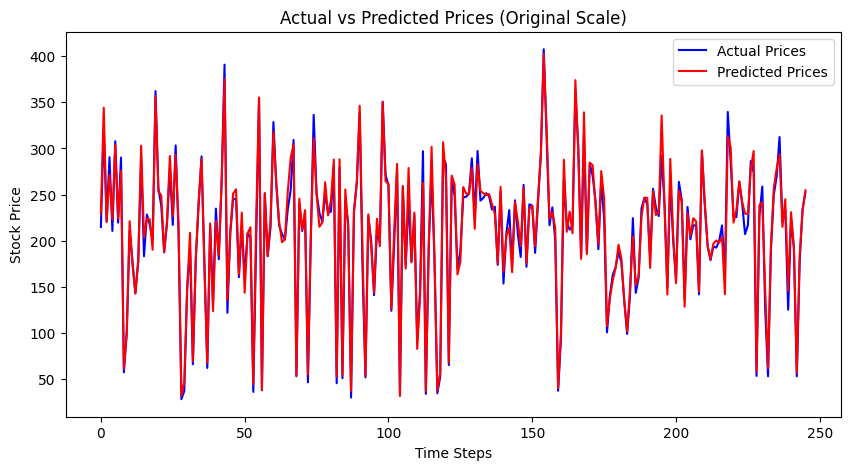

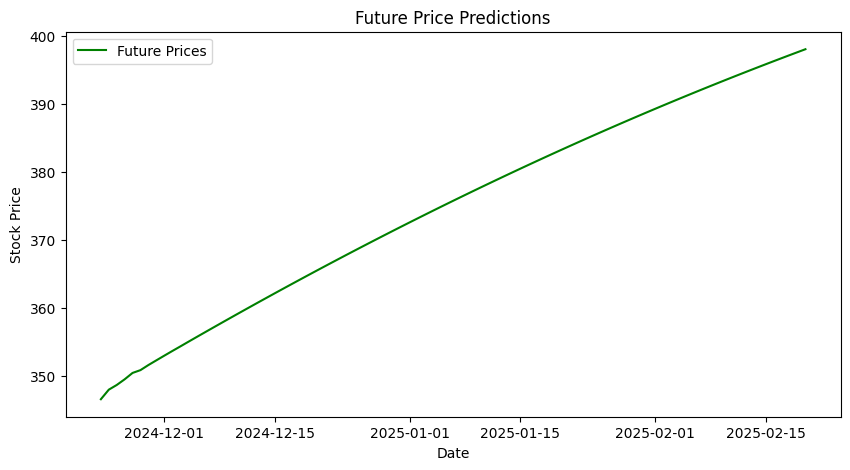

[datetime.datetime(2024, 11, 25, 0, 0), datetime.datetime(2024, 11, 26, 0, 0), datetime.datetime(2024, 11, 27, 0, 0), datetime.datetime(2024, 11, 28, 0, 0)] [348.66923473873135, 349.5008501081936, 350.44024702487627, 350.8523745884902]
The predicted stock price for 2025-02-20 is $397.99


In [1]:
from datetime import timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Step 2: Prepare the data with lagged features and scaling
def prepare_data(data, lag=5):
    data['Date'] = data.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    data['Scaled_Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data['Scaled_Close'].values[i-lag:i])
        y.append(data['Scaled_Close'].values[i])
    
    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

# Step 3: Train a GRU model
def train_gru_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(X.shape[1], 1)),
        GRU(50),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    y_pred = model.predict(X_test)
    return model, X_train, X_test, y_train, y_test, y_pred

# Step 4: Evaluate model performance with proper inverse scaling
def evaluate_model(y_test, y_pred, scaler):
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return y_test_original, y_pred_original

# Step 5: Predict future prices
def predict_future_prices(model, last_known_data, scaler, days=90):
    future_prices = []
    current_data = last_known_data.copy()
    
    for _ in range(days):
        current_data_scaled = scaler.transform(current_data.reshape(-1, 1))
        current_data_scaled = np.array([current_data_scaled])
        
        next_price_scaled = model.predict(current_data_scaled)[0, 0]
        next_price = scaler.inverse_transform([[next_price_scaled]])[0, 0]
        future_prices.append(next_price)
        
        # Update lagged features for the next prediction
        current_data = np.roll(current_data, shift=-1)
        current_data[-1] = next_price
    
    future_dates = [last_date + timedelta(days=i) for i in range(1, days + 1)]
    return future_dates, future_prices

# Step 6: Plot predictions
def plot_results1(y_test_original, y_pred_original):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_original, label='Actual Prices', color='blue')
    plt.plot(y_pred_original, label='Predicted Prices', color='red')
    plt.legend()
    plt.title('Actual vs Predicted Prices (Original Scale)')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.show()

def plot_results2(future_dates, future_prices):
    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, future_prices, label='Future Prices', color='green')
    plt.legend()
    plt.title('Future Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.show()

# Example usage
if __name__ == "__main__":
    ticker = 'TSLA'  # Example stock ticker
    start_date = '2020-01-01'
    end_date = '2024-11-25'
    
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    features, targets, scaler = prepare_data(stock_data, lag=5)
    
    # Reshape features for GRU model
    features = features.reshape(features.shape[0], features.shape[1], 1)
    
    model, X_train, X_test, y_train, y_test, y_pred = train_gru_model(features, targets)
    y_test_original, y_pred_original = evaluate_model(y_test, y_pred, scaler)
    
    # Predict future prices
    last_known_data = stock_data['Close'].values[-5:]  # Last 5 known prices
    last_date = stock_data.index[-1].to_pydatetime().replace(tzinfo=None)
    future_dates, future_prices = predict_future_prices(model, last_known_data, scaler, days=90)
    
    # Plot results
    plot_results1(y_test_original, y_pred_original)
    plot_results2(future_dates, future_prices)
    
    # Print future prices
    print(future_dates[2:6], future_prices[2:6])
    print(f"The predicted stock price for {future_dates[-1].strftime('%Y-%m-%d')} is ${future_prices[-1]:.2f}")
